Household: 
- $V(k,K,z) = \max_{c,k'} \{u(c)+βE[V(k',K',z')|z]\}$
- $u(c) = c^{(1-\sigma)}/(1-\sigma)$
- $c+k'=(1-\tau(K,z))(f(K,z)+(k-K)(f_1(K,z)+(1-\delta)k+d(K,z)=y(k,K,z)$
- $c,k' \in [0,y(k,K,z)]$
- $f(k,z) = zk^\alpha$
- $f_{1}(k,z) = z\alpha k^{\alpha-1}$
- $F(k,z) = zk^\alpha +(1-\delta)k$

Tax: 
- Tax Policy: $\tau(K,z)$ s.t. $(1-\tau(K,z))f_1(K,z)$ falling in $K$
- Transfer: $d(K,z) = \tau(K,z)$

Solution: 
- Find $k_{ss}$ from $1=\beta*(1-\tau(k_{ss},E[z])\alpha k_{ss}^{\alpha-1}+1-\delta)$ 
- Guess $c_{t}(k,z)$ in $[k_{ss}*0.9, k_{ss}*1.1]$x$Z$
- Define $H(k,z)=(1-\delta)+(1-\tau(k,z))f_{1}(k,z)$
- For each $k,z$, update $c_{t+1}(k,z)$ with $c$ that solves: $u'(c)-\beta E[u'(c_{t}(f(k,z)-c,z')) H(f(k,z)-c,z')|z]=0$ until convergence
- Store policy rules $c(k,z)$ and $k'(k,z) = f(k,z)+(1-\delta)k - c(k,z)$
- From initial $k_{0},z_{0}$ simulate economy with $k_{t+1}=k'(k_{t},z_{t})$ and $c_{t}=c(k_{t},z_{t})$

In [10]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, LaTeXStrings, Parameters, Plots, QuantEcon, Roots
using Optim, Random
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots
σ = 2.0;
β = 0.99;
α = 0.36;
δ = 0.025;
τ = 0.1;
Z = [0.99 1.01]
P = Array([0.9 0.1; 0.1 0.9])
up(c) = c^(-σ)
f(k,z) = z*k^α
F(k,z) = z*k^α+(1-δ)*k
fp(k,z) = z*α*k^(α-1)
H(k,z) = (1-τ)*fp(k,z)+(1-δ)
Kss = ((1/β+δ-1)/(α*(1-τ)))^(1/(α-1))
Css = Kss^α-δ*Kss
println((Kss,Css))
K = Array(range(Kss*0.9, Kss*1.1, 200))
    
function coleman!(Kg1, Kg2, g1, g2, K, β, up, f, fp)
    c1 = LinearInterpolation(K, g1, extrapolation_bc = Line()) # c(k,z1)
    c2 = LinearInterpolation(K, g2, extrapolation_bc = Line()) # c(k,z2)
    for (i,k) in enumerate(K)
        function h1(c) # Euler at k,z1
            kp = F(k,Z[1])-c 
            val1 = up.(c1.(kp)).* H(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* H(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[1,1]*val1+P[1,2]*val2)
        end
        function h2(c) # Euler at k,z2
            kp = F(k,Z[2])-c 
            val1 = up.(c1.(kp)).* H(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* H(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[2,1]*val1+P[2,2]*val2)
        end
        Kg1[i] = find_zero(h1, (1e-10, F(k,Z[1])-1e-10)) # Update c(k,z1)
        Kg2[i] = find_zero(h2, (1e-10, F(k,Z[2])-1e-10)) # Update c(k,z2)
    end
    return Kg1,Kg2
end
coleman(g1, g2, K, β, up, f, fp) = coleman!(similar(g1), similar(g2), g1, g2, K, β, up, f, fp)

function timeIteration(c1_init, c2_init)
    c1 = c1_init
    c2 = c2_init
    error=1
    while error>1e-6
        new_c1, new_c2 = coleman(c1, c2, K, β, up, f, fp)
        error = norm(c1-new_c1)+norm(c2-new_c2)
        c1 = new_c1
        c2 = new_c2        
    end
    return c1,c2
end
c1,c2 = timeIteration(1/13*K, 1/13*K)

(32.22290426894504, 2.6853424804002026)


timeIteration (generic function with 1 method)

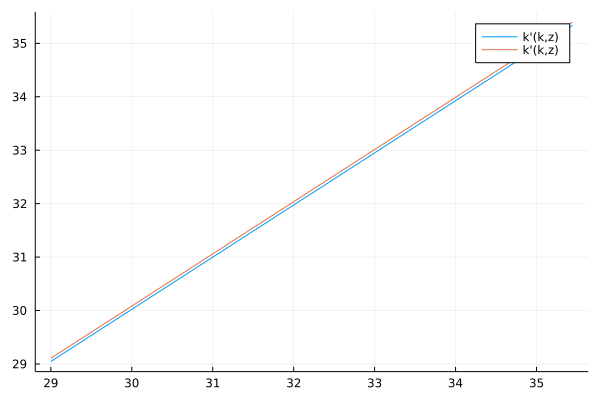

In [15]:
k1 = F.(K,Z[1]) - c1;
k2 = F.(K,Z[2]) - c2;
KP = hcat(k1,k2)
CP = hcat(c1,c2)
plot(K, KP, label="k'(k,z)")

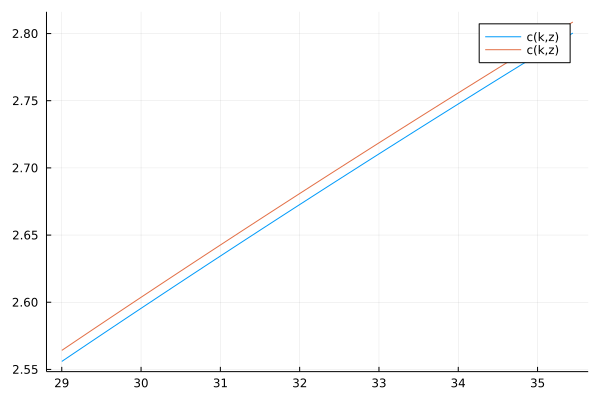

In [16]:
plot(K, CP, label="c(k,z)")

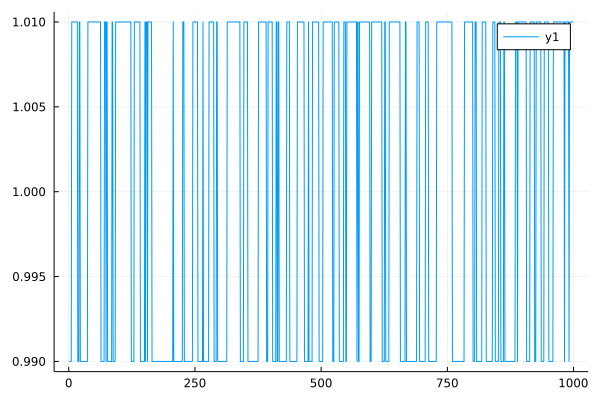

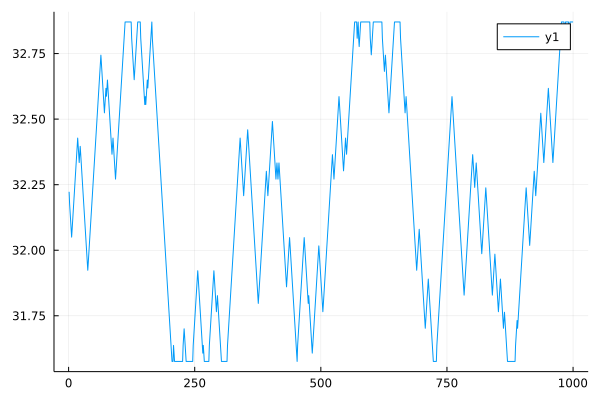

In [17]:
# Simulate
using QuantEcon
k0 = Kss
z0 = Z[1]
T = 1000
ZIND = simulate(MarkovChain(P), T);
KIND = simulate(MarkovChain(P), T);
KPATH = k0*Array(1:T)
ZPATH = z0*Array(1:T-1);
for i in 1:T-1
    z = ZIND[i]
    KIND[i] = partialsortperm(abs.(K .- KPATH[i]), 1)
    KPATH[i+1] = KP[KIND[i], z]
    ZPATH[i] = Z[z]
    #println((z, KIND[i], KPATH[i], KPATH[i+1], ZPATH[i]))
end
display(plot(ZPATH))
display(plot(KPATH))